## Installing libraries to use ##

In [31]:
#!pip install geocoder
#!pip install folium
!pip install geopy
#!pip install bs4
#!pip install lxml
#!conda install requests anaconda -y

In [32]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import requests


from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


## Clean and Extract Data ##
this can be found at : https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [33]:
wiki = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wiki_page = requests.get(wiki)
wiki_data = pd.read_html(wiki_page.content, header =0)[0]

Convert to dataframe

In [34]:
df = wiki_data[wiki_data.Neighbourhood != 'Not assigned']
df.reset_index(inplace = True)
df.head()

,index,Postal Code,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [35]:
df.groupby(['Postal Code']).first()
df.head()

,index,Postal Code,Borough,Neighbourhood
0,2,M3A,North York,Parkwoods
1,3,M4A,North York,Victoria Village
2,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,5,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [36]:
df[df['Borough'] == 'Not assigned']

,index,Postal Code,Borough,Neighbourhood


In [37]:
df = df.reset_index()

In [38]:
df.drop(['index'], axis = 'columns', inplace = True)
df.head()


,level_0,Postal Code,Borough,Neighbourhood
0,0,M3A,North York,Parkwoods
1,1,M4A,North York,Victoria Village
2,2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [39]:
df = df.set_index('level_0')
df.head()

,Postal Code,Borough,Neighbourhood
level_0,,,
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [40]:
df = df.rename(index = {'level_0' : 'index'})
df.index.name = 'index'
df.head()

,Postal Code,Borough,Neighbourhood
index,,,
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [41]:
df.describe()

,Postal Code,Borough,Neighbourhood
count,103,103,103
unique,103,10,99
top,M4G,North York,Downsview
freq,1,24,4


In [42]:
def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.70909000000006, -79.36409999999995]

In [43]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighbourhood'].tolist()))
                    
grp = df.groupby(['Postal Code', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighbourhood')

In [44]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postal Code']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [45]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [46]:
df_2.head(10)

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520
3,M1G,Scarborough,Woburn,43.76820,-79.21761
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944
5,M1J,Scarborough,Scarborough Village,43.74309,-79.23526
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.72861,-79.26367
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.71406,-79.28412
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.69539,-79.26194


In [60]:
import geopy
address = 'Scarborough,Toronto'
geopy.geocoders.options.default_user_agent = "my-app"

geolocator = Nominatim(user_agent="my-app")
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Seattle,Washington are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Seattle,Washington are 43.773077, -79.257774.


## map of scarborough ##

In [62]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighbourhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [63]:
address = 'Scarborough,Toronto'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.773077, -79.257774.


In [64]:

CLIENT_ID = '2FYZPI50FSO30GBTBNW4RWRFBYUUPU4F2NNBG1YX4PD4O02Q' # my Foursquare ID
CLIENT_SECRET = 'Y5FI3HQPSY3FKR2MCYSVVRS34IT400YPKPA2H02VOITQVPKX' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: 2FYZPI50FSO30GBTBNW4RWRFBYUUPU4F2NNBG1YX4PD4O02Q
CLIENT_SECRET: Y5FI3HQPSY3FKR2MCYSVVRS34IT400YPKPA2H02VOITQVPKX


In [65]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude_n1, 
   longitude_n1, 
    radius, 
   LIMIT)
results = requests.get(url).json()

In [66]:
venues=results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.events.count',
       'venue.events.summary', 'venue.venuePage.id'],
      dtype='object')

In [67]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## Nearby Venues ##

In [68]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,DAVIDsTEA,"[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",43.776320,-79.258688
4,Chipotle Mexican Grill,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",43.776410,-79.258069


In [69]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,DAVIDsTEA,Tea Room,43.776320,-79.258688
4,Chipotle Mexican Grill,Mexican Restaurant,43.776410,-79.258069


In [70]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store        8
Coffee Shop           5
Restaurant            4
Tea Room              2
Gas Station           2
Pharmacy              2
Sandwich Place        2
Food Court            2
Mexican Restaurant    1
Deli / Bodega         1
Name: categories, dtype: int64

In [71]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [73]:
# Nearby Venues
Scarborough_venues = getNearbyVenues(names=df_2['Neighbourhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [74]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 298 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,33,33,33,33,33,33
"Alderwood, Long Branch",6,6,6,6,6,6
"Bathurst Manor, Wilson Heights, Downsview North",4,4,4,4,4,4
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",26,26,26,26,26,26


In [75]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Board Shop,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cemetery,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Science Museum,Seafood Restaurant,Shipping Store,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Street Art,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tech Startup,Tennis Court,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,

In [76]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                venue  freq
0       Shopping Mall  0.09
1  Chinese Restaurant  0.09
2         Pizza Place  0.06
3       Grocery Store  0.03
4     Bubble Tea Shop  0.03


---- Alderwood, Long Branch ----
            venue  freq
0     Coffee Shop  0.17
1             Pub  0.17
2     Pizza Place  0.17
3             Gym  0.17
4  Sandwich Place  0.17


---- Bathurst Manor, Wilson Heights, Downsview North ----
                  venue  freq
0                  Park  0.50
1     Convenience Store  0.25
2  Other Great Outdoors  0.25
3                Museum  0.00
4             Nightclub  0.00


---- Bayview Village ----
                venue  freq
0                Park  0.25
1               Trail  0.25
2    Asian Restaurant  0.25
3  Golf Driving Range  0.25
4         Zoo Exhibit  0.00


---- Bedford Park, Lawrence Manor East ----
                venue  freq
0         Coffee Shop  0.08
1      Sandwich Place  0.08
2         Pizza Place  0.08
3  Italian Restaurant  0.08
4          

In [77]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## common venues ##

In [78]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Shopping Mall,Chinese Restaurant,Pizza Place,Japanese Restaurant,Latin American Restaurant,Bakery,Bank,Motorcycle Shop,Sushi Restaurant,Supermarket
1,"Alderwood, Long Branch",Pizza Place,Gas Station,Pub,Sandwich Place,Coffee Shop,Gym,Yoga Studio,Ethiopian Restaurant,Doner Restaurant,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,Convenience Store,Other Great Outdoors,Yoga Studio,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
3,Bayview Village,Golf Driving Range,Asian Restaurant,Trail,Park,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Pizza Place,Coffee Shop,Restaurant,Sandwich Place,Breakfast Spot,Pharmacy,Comfort Food Restaurant,Pub,Café


## K means Clustering ##

In [81]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0], dtype=int32)

In [97]:
#neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

Scarborough_merged.head()# check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labelss,Cluster Label,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.81153,-79.19552,1,1,1,Zoo Exhibit,Construction & Landscaping,Electronics Store,Fast Food Restaurant,Falafel Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Ethiopian Restaurant,Event Space
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.78564,-79.15871,1,1,1,Home Service,Fish & Chips Shop,Bar,Moving Target,Falafel Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.76575,-79.17520,0,0,0,Park,Athletics & Sports,Gym / Fitness Center,Yoga Studio,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
3,M1G,Scarborough,Woburn,43.76820,-79.21761,1,1,1,Chinese Restaurant,Fast Food Restaurant,Park,Coffee Shop,Yoga Studio,Event Space,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
4,M1H,Scarborough,Cedarbrae,43.76969,-79.23944,1,1,1,Bank,Bakery,Flower Shop,Thai Restaurant,Caribbean Restaurant,Indian Restaurant,Gas Station,Hakka Restaurant,Athletics & Sports,Ethiopian Restaurant


In [98]:
kclusters = 10

In [100]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighbourhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


In [101]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [103]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighbourhood":df_2["Neighbourhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0
                                                              
                                                              
                                                              ]})

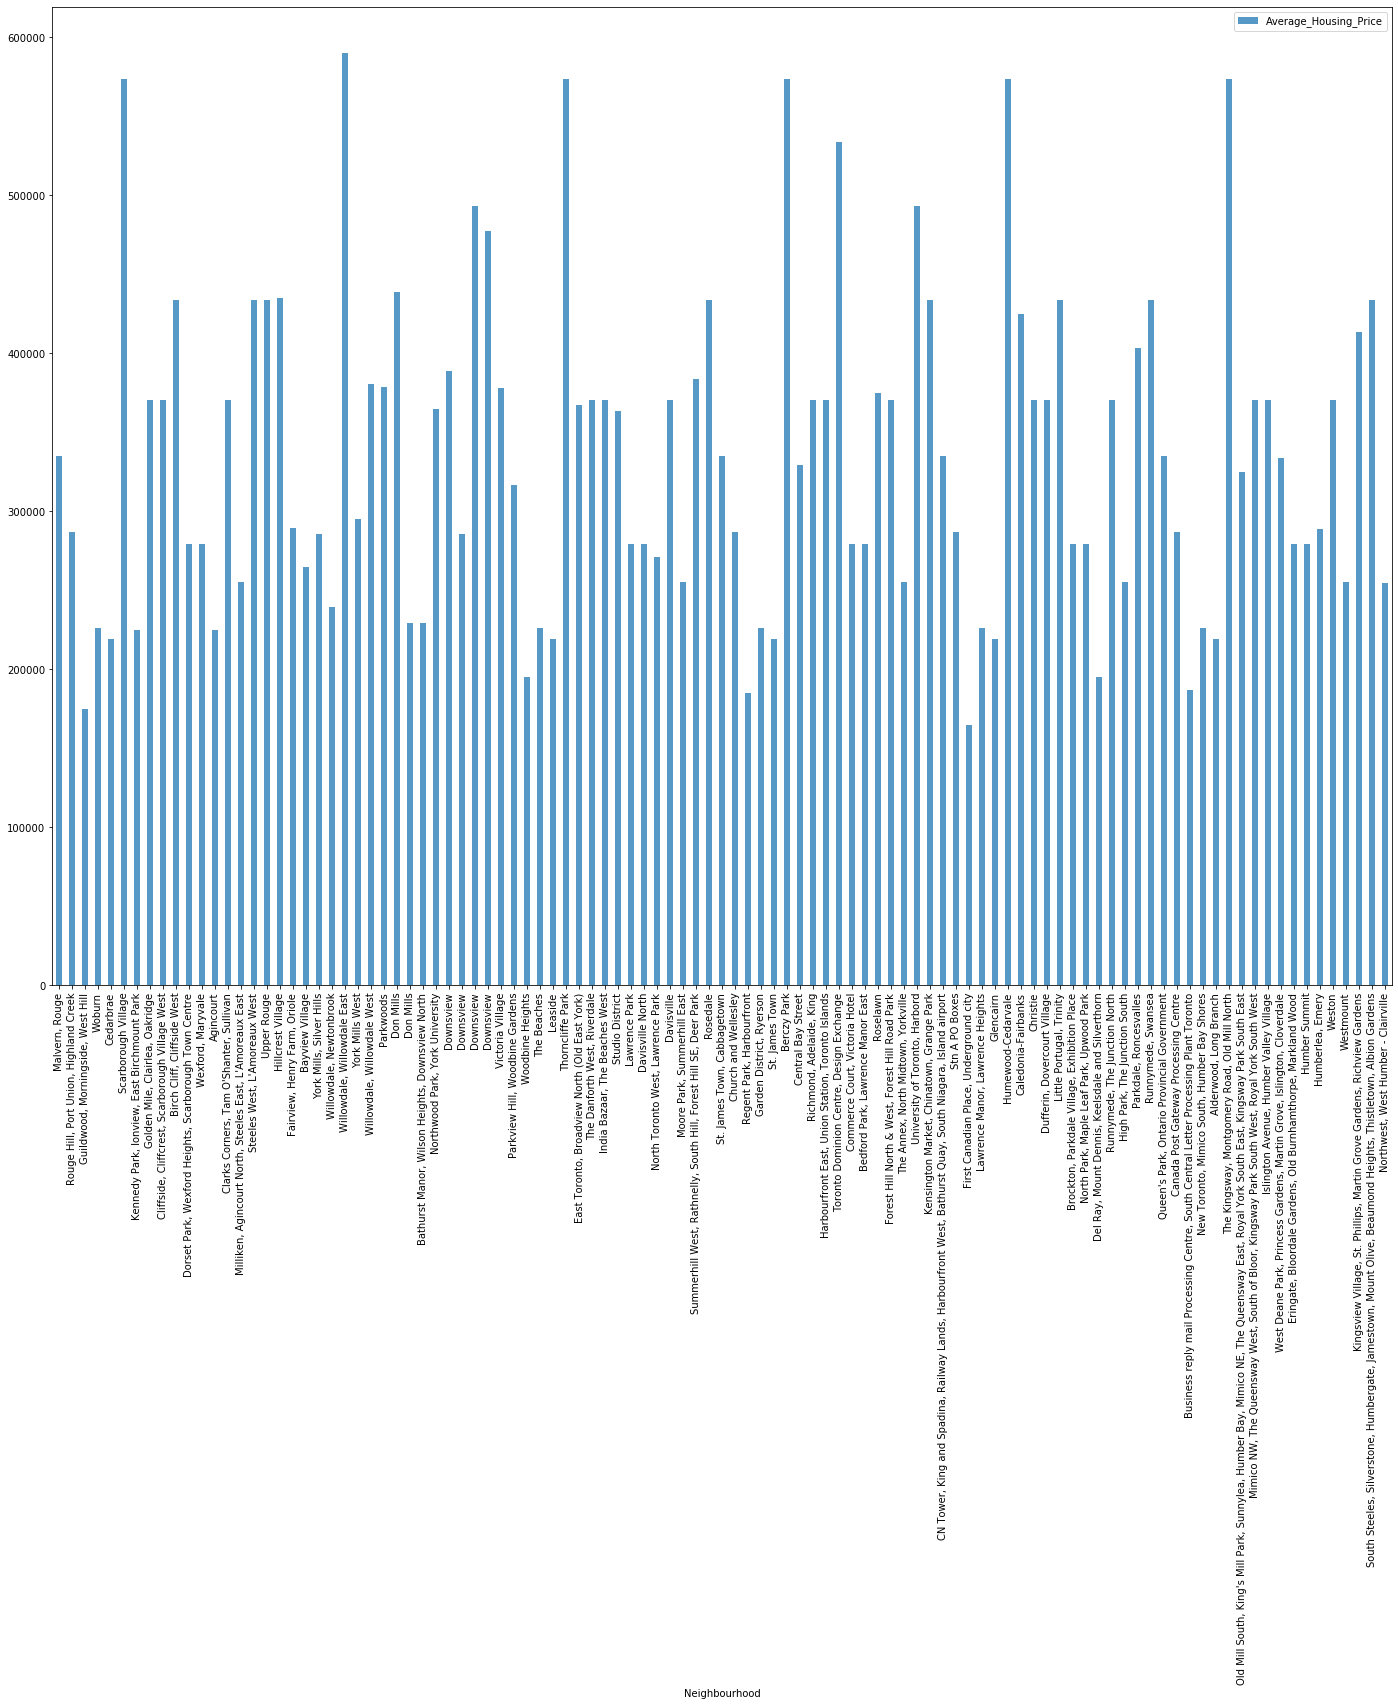

In [105]:
Scarborough_Avg_HousingPrice.set_index('Neighbourhood',inplace=True,drop=True)
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

## Cluster Rating of Schools ##

In [107]:
clusters=pd.DataFrame({"Cluster1":df1["Neighbourhood"],
                      "Cluster2":df2["Neighbourhood"],
                      "Cluster4":df3["Neighbourhood"]})
clusters = clusters.replace(np.nan, '', regex=True)

In [109]:
new_Scarborough=Scarborough_merged.set_index("Neighbourhood",drop=True)
#Source:https://www.greatschools.org
Scarborough_school_ratings=pd.DataFrame({"Neighbourhood":df["Neighbourhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7
                                                           ]})

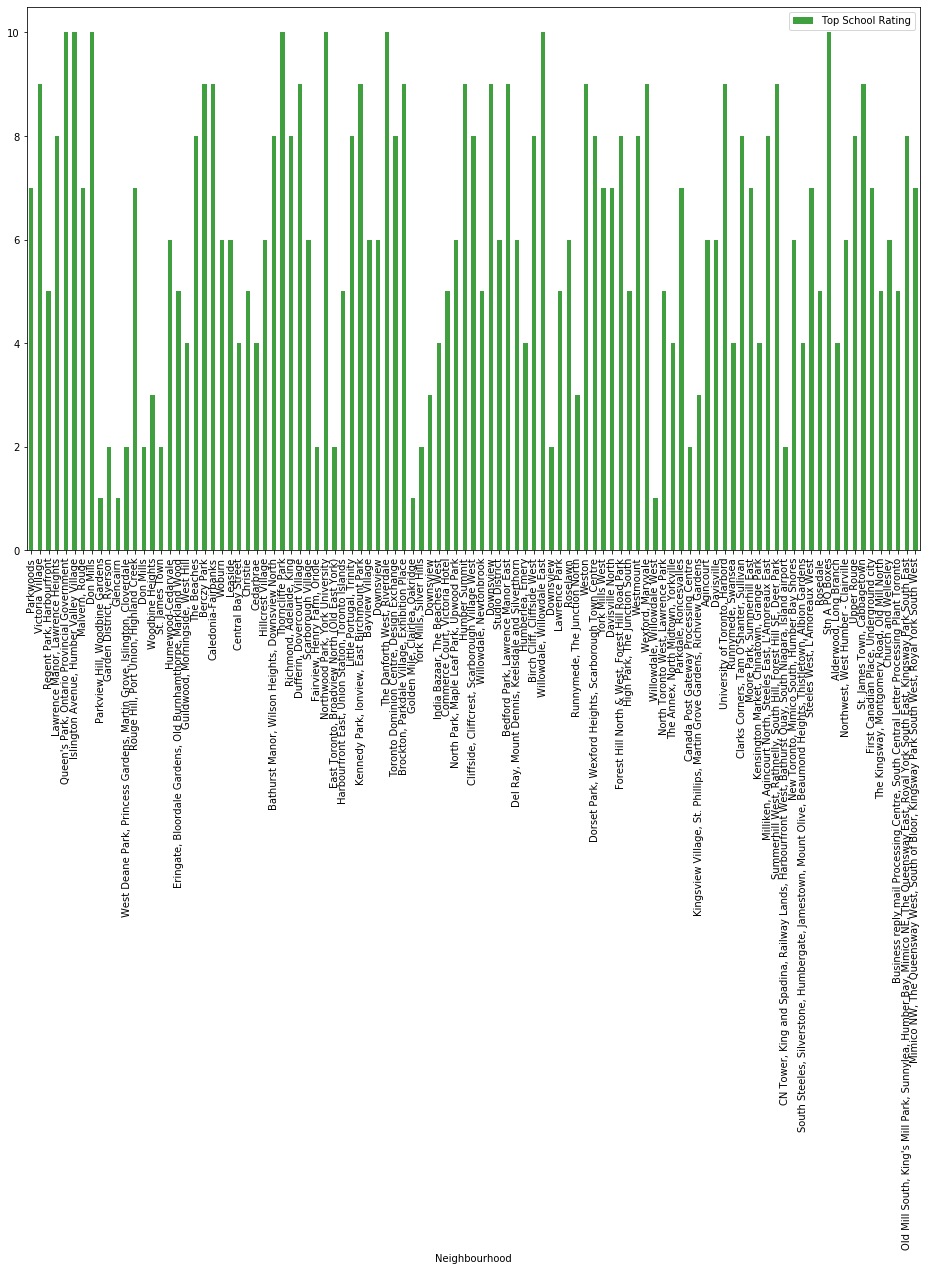

In [110]:
Scarborough_school_ratings.set_index('Neighbourhood',inplace=True,drop=True)
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);